# Make Dataset

In [38]:
!python coco2rcnn.py -i '/drive0-storage/robot_pose/HumanoidRobotPoseEstimation/dataset/hrp/merge_train_2.json' -s '/drive0-storage/robot_pose/HumanoidRobotPoseEstimation/dataset/hrp/images/' -t 'rcnn_robot' -n 'train'

100%|█████████████████████████████████████| 1848/1848 [00:00<00:00, 4752.62it/s]


In [5]:
!python coco2rcnn.py -i '/drive0-storage/robot_pose/HumanoidRobotPoseEstimation/dataset/hrp/merge_val_2.json' -s '/drive0-storage/robot_pose/HumanoidRobotPoseEstimation/dataset/hrp/images/' -t 'rcnn_robot' -n 'test'

100%|███████████████████████████████████████| 253/253 [00:00<00:00, 3554.11it/s]


# 1. Imports

In [2]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.tensorboard import SummaryWriter

import albumentations as A # Library for augmentations

In [3]:
# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

In [3]:
import pycocotools
print(pycocotools.__file__)

/home/riset/.local/lib/python3.10/site-packages/pycocotools/__init__.py


# 2. Augmentations

In [4]:
def train_transform():
    return A.Compose([
        A.Sequential([
            # A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            # ERROR if using randomscale
            # A.RandomScale(scale_limit=0.4),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more here https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

# 3. Dataset class

In [5]:
import os.path

class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])
        
        if not os.path.isfile(img_path): print('img error: ', img_path)
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are glue tubes
            bboxes_labels_original = ['Robot' for _ in bboxes_original]            

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,6,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

# 4. Visualizing a random item from dataset

In [6]:
KEYPOINTS_FOLDER_TRAIN = 'rcnn_robot/train'
# KEYPOINTS_FOLDER_TRAIN = 'glue_tubes_keypoints_dataset_134imgs/train'

dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

Original targets:
 ({'boxes': tensor([[244.,  47., 379., 380.]]), 'labels': tensor([1]), 'image_id': tensor([1072]), 'area': tensor([44955.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[334.,  47.,   1.],
         [323., 191.,   1.],
         [244., 204.,   1.],
         [379., 207.,   1.],
         [279., 380.,   1.],
         [352., 371.,   1.]]])},) 


Transformed targets:
 ({'boxes': tensor([[244.,  47., 379., 380.]]), 'labels': tensor([1]), 'image_id': tensor([1072]), 'area': tensor([44955.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[334.,  47.,   1.],
         [323., 191.,   1.],
         [244., 204.,   1.],
         [379., 207.,   1.],
         [279., 380.,   1.],
         [352., 371.,   1.]]])},)


[1072]


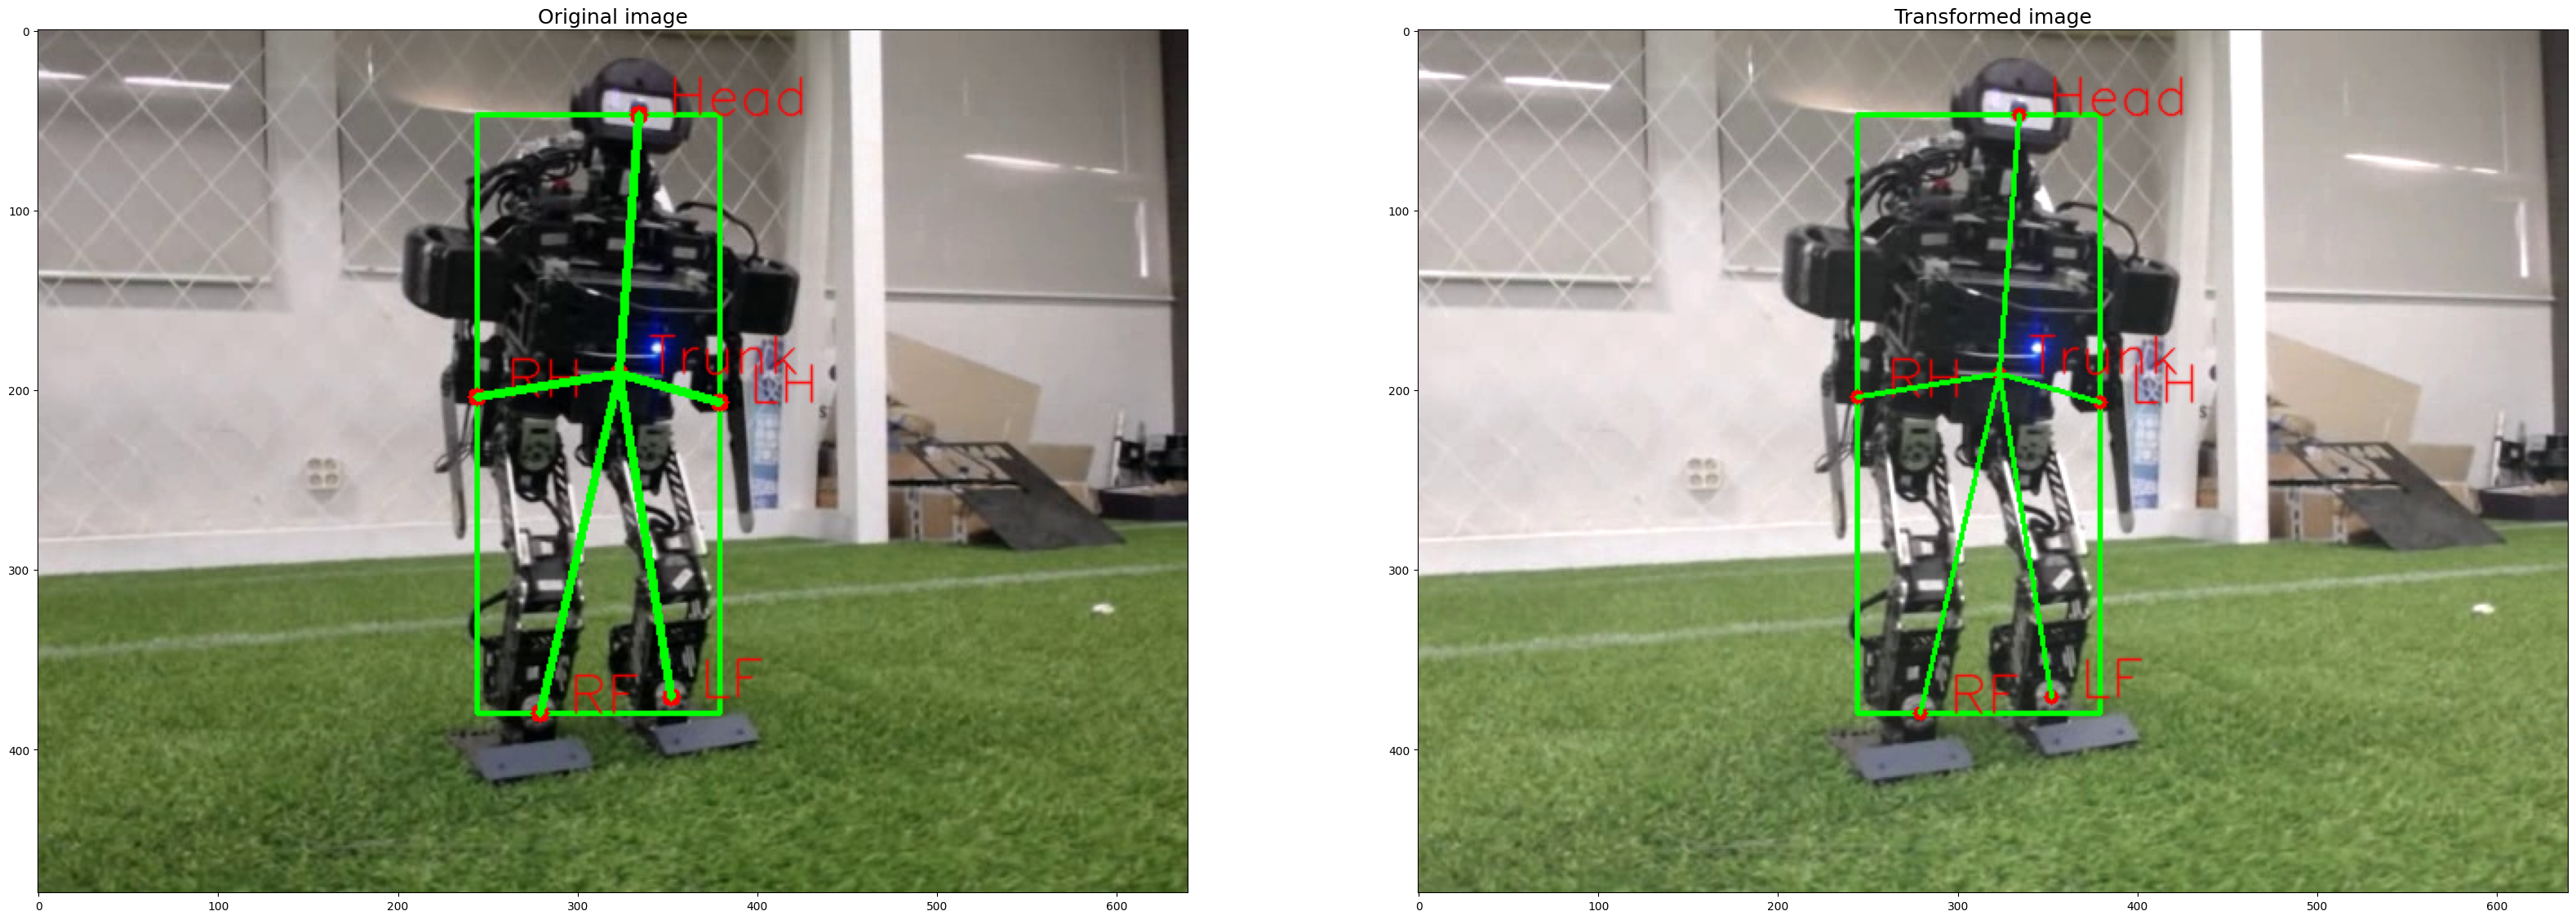

In [26]:
keypoints_classes_ids2names = {0: 'Head', 1: 'Trunk', 2: 'RH', 3: 'LH', 4: 'RF', 5: 'LF'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        start_point = None
        for idx, kp in enumerate(kps):
            # print(tuple(kp))
            image = cv2.circle(image.copy(), tuple(kp), 4, (255,0,0), -1)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)
            if start_point:
                image = cv2.line(image, start_point, tuple(kp), (0, 255, 0), 2)
            if idx < 2:
                start_point = tuple(kp)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            start_point = None
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), -1)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)
                if start_point:
                    image_original = cv2.line(image_original, start_point, tuple(kp), (0, 255, 0), 3)
                if idx < 2:
                    start_point = tuple(kp)
                
        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()
print(batch[1][0]['image_id'].detach().cpu().numpy().astype(np.int32).tolist())

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])
# print(keypoints)
# print(np.array(keypoints).shape)

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

# 5. Training

In [7]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [10]:
output_dir = 'ichiro_nimbro_merge'

writer = SummaryWriter(output_dir)

In [ ]:
# device = torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


KEYPOINTS_FOLDER_TRAIN = 'rcnn_robot/train'
KEYPOINTS_FOLDER_TEST = 'rcnn_robot/test'

# KEYPOINTS_FOLDER_TRAIN = 'glue_tubes_keypoints_dataset_134imgs/train'
# KEYPOINTS_FOLDER_TEST = 'glue_tubes_keypoints_dataset_134imgs/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 6)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 100

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000, writer=writer)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model weights after training
torch.save(model.state_dict(), os.path.join(output_dir, 'keypointsrcnn_weights.pth'))
writer.close()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

Epoch: [0]  [  0/616]  eta: 0:19:29  lr: 0.000003  loss: 9.5670 (9.5670)  loss_classifier: 0.7536 (0.7536)  loss_box_reg: 0.0631 (0.0631)  loss_keypoint: 8.0514 (8.0514)  loss_objectness: 0.6929 (0.6929)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 1.8987  data: 0.2254  max mem: 2808
Epoch: [0]  [615/616]  eta: 0:00:00  lr: 0.001000  loss: 4.8860 (6.0152)  loss_classifier: 0.0726 (0.1169)  loss_box_reg: 0.0916 (0.0684)  loss_keypoint: 4.7634 (5.5996)  loss_objectness: 0.0426 (0.1932)  loss_rpn_box_reg: 0.0163 (0.0372)  time: 0.4065  data: 0.0264  max mem: 3140
Epoch: [0] Total time: 0:04:19 (0.4218 s / it)
creating index...
index created!
Test:  [  0/253]  eta: 0:00:27  model_time: 0.0918 (0.0918)  evaluator_time: 0.0081 (0.0081)  time: 0.1070  data: 0.0064  max mem: 3140
Test:  [100/253]  eta: 0:00:15  model_time: 0.0967 (0.0901)  evaluator_time: 0.0091 (0.0066)  time: 0.1127  data: 0.0070  max mem: 3140
Test:  [200/253]  eta: 0:00:05  model_time: 0.0650 (0.0862)  evaluator_time: 0.0027 

In [ ]:
# device = torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


KEYPOINTS_FOLDER_TRAIN = 'rcnn_robot/train'
KEYPOINTS_FOLDER_TEST = 'rcnn_robot/test'

# KEYPOINTS_FOLDER_TRAIN = 'glue_tubes_keypoints_dataset_134imgs/train'
# KEYPOINTS_FOLDER_TEST = 'glue_tubes_keypoints_dataset_134imgs/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 6)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000, writer=writer)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model weights after training
torch.save(model.state_dict(), os.path.join(output_dir, 'keypointsrcnn_weights.pth'))
writer.close()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

Epoch: [0]  [  0/616]  eta: 0:17:33  lr: 0.000003  loss: 9.4949 (9.4949)  loss_classifier: 0.6809 (0.6809)  loss_box_reg: 0.0157 (0.0157)  loss_keypoint: 8.0855 (8.0855)  loss_objectness: 0.6938 (0.6938)  loss_rpn_box_reg: 0.0190 (0.0190)  time: 1.7109  data: 0.1127  max mem: 2409
Epoch: [0]  [615/616]  eta: 0:00:00  lr: 0.001000  loss: 4.8175 (5.9840)  loss_classifier: 0.0636 (0.1189)  loss_box_reg: 0.0858 (0.0699)  loss_keypoint: 4.6408 (5.5709)  loss_objectness: 0.0227 (0.1837)  loss_rpn_box_reg: 0.0092 (0.0406)  time: 0.4252  data: 0.0466  max mem: 3152
Epoch: [0] Total time: 0:04:18 (0.4198 s / it)
creating index...
index created!
Test:  [  0/253]  eta: 0:00:22  model_time: 0.0734 (0.0734)  evaluator_time: 0.0060 (0.0060)  time: 0.0872  data: 0.0069  max mem: 3152
Test:  [100/253]  eta: 0:00:12  model_time: 0.0791 (0.0721)  evaluator_time: 0.0067 (0.0045)  time: 0.0915  data: 0.0068  max mem: 3152
Test:  [200/253]  eta: 0:00:04  model_time: 0.0619 (0.0734)  evaluator_time: 0.0023 

In [20]:
# TEST
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
KEYPOINTS_FOLDER_TEST = 'rcnn_robot/test'
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

state_dict = torch.load('keypointsrcnn_weights.pth', map_location=device)
model = get_model(num_keypoints = 6)
model.load_state_dict(state_dict)
model = model.to(device)


evaluate(model, data_loader_test, device)

creating index...
index created!
Test:  [  0/253]  eta: 0:00:20  model_time: 0.0696 (0.0696)  evaluator_time: 0.0028 (0.0028)  time: 0.0795  data: 0.0065  max mem: 863
Test:  [100/253]  eta: 0:00:11  model_time: 0.0657 (0.0627)  evaluator_time: 0.0044 (0.0027)  time: 0.0767  data: 0.0064  max mem: 863
Test:  [200/253]  eta: 0:00:03  model_time: 0.0571 (0.0624)  evaluator_time: 0.0013 (0.0027)  time: 0.0655  data: 0.0060  max mem: 863
Test:  [252/253]  eta: 0:00:00  model_time: 0.0571 (0.0614)  evaluator_time: 0.0013 (0.0024)  time: 0.0646  data: 0.0053  max mem: 863
Test: Total time: 0:00:17 (0.0704 s / it)
Averaged stats: model_time: 0.0571 (0.0614)  evaluator_time: 0.0013 (0.0024)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.815
 Average Precision  (AP) @[ I

# 6. Visualizing model predictions

In [12]:
iterator = iter(data_loader_test)

In [13]:
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

# print("Predictions: \n", output)

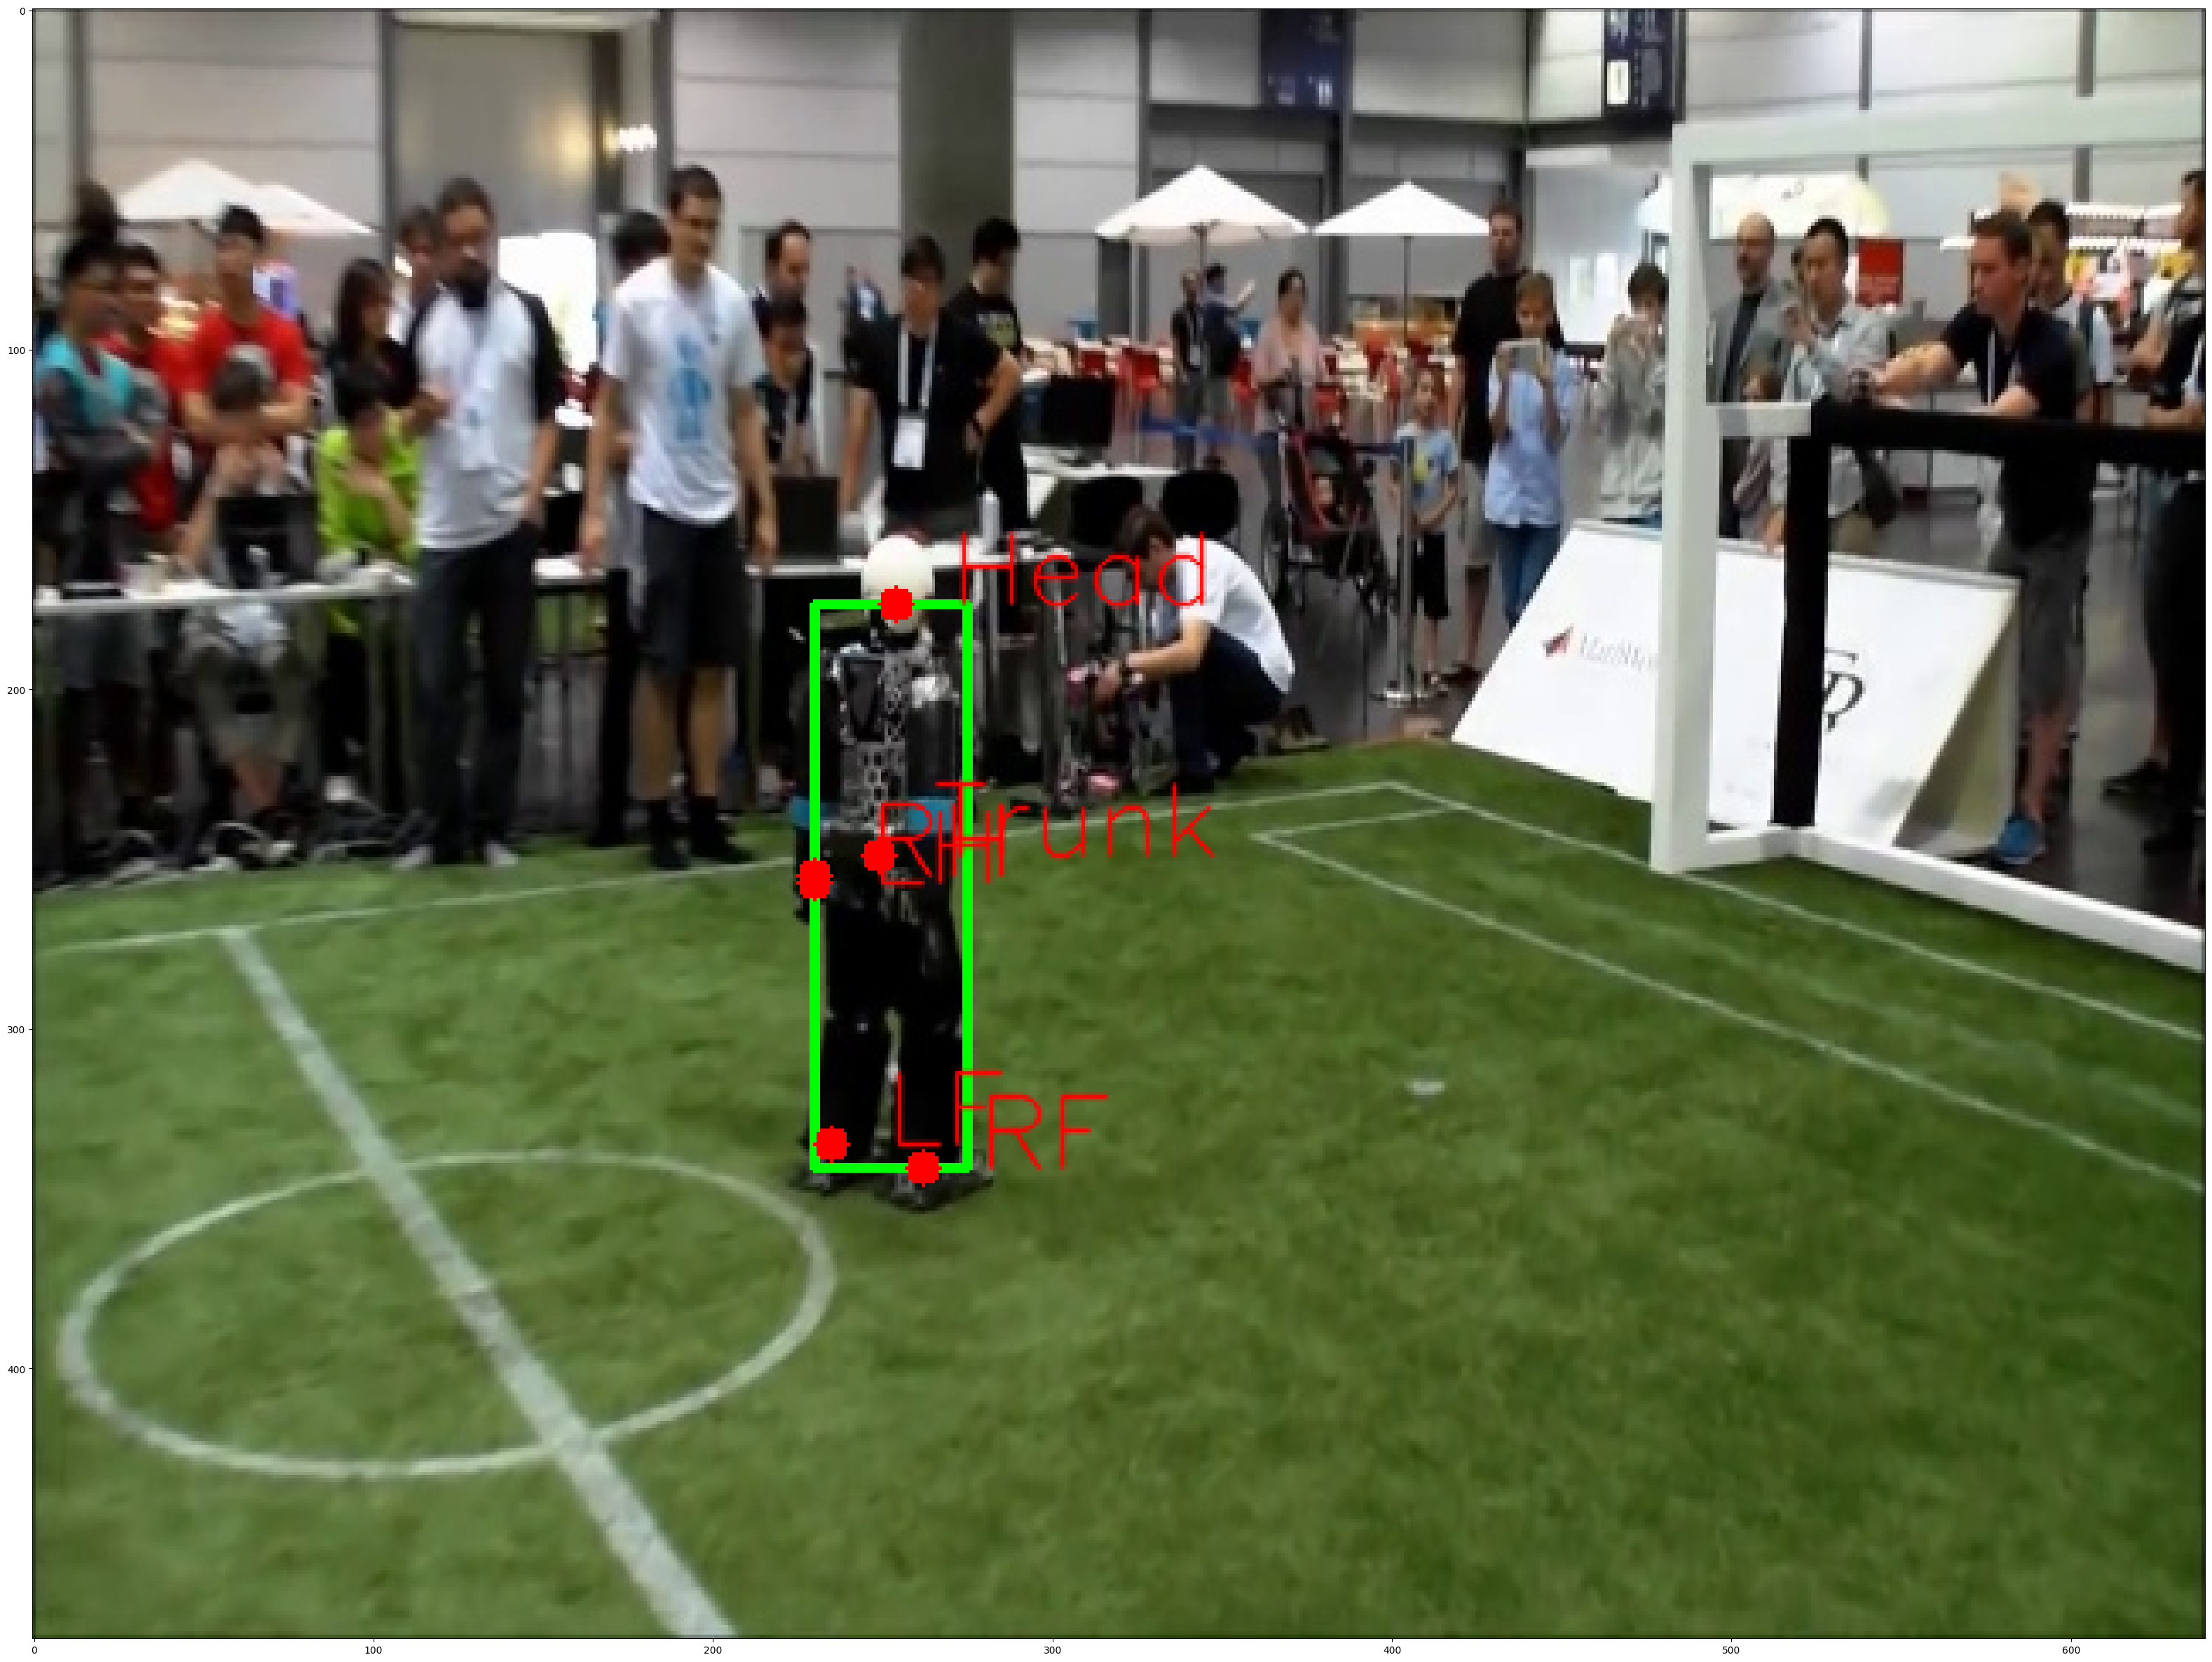

In [14]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.55)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)

## Visualizing from model file

In [19]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))

model_ = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=6,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

# load the model checkpoint
with torch.no_grad():
    # model_.load_state_dict(torch.load('ichiro_nimbro_merge/keypointsrcnn_weights.pth'))
    model_.load_state_dict(torch.load('keypointsrcnn_weights.pth'))
    model_.to(device)
    model_.eval()

In [20]:
import time

# image = cv2.imread('/drive0-storage/robot_pose/keypoint_rcnn_training_pytorch/rcnn_robot/train/images/1826.jpg')
image = cv2.imread('e.jpeg')
start_time = time.time()

with torch.no_grad():
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_frame = image.copy()
    image = image / 255.0
    image = np.transpose(image, (2, 0, 1))
    image = torch.tensor(image, dtype=torch.float)
    image = image.unsqueeze(0).to(device)
    outputs = model_(image)
print("--- %s seconds ---" % (time.time() - start_time))
# outputs

--- 1.487062931060791 seconds ---


[[[230, 122], [230, 122], [229, 187], [293, 195], [244, 275], [270, 275]], [[411, 118], [403, 182], [359, 191], [428, 182], [385, 274], [411, 274]]]


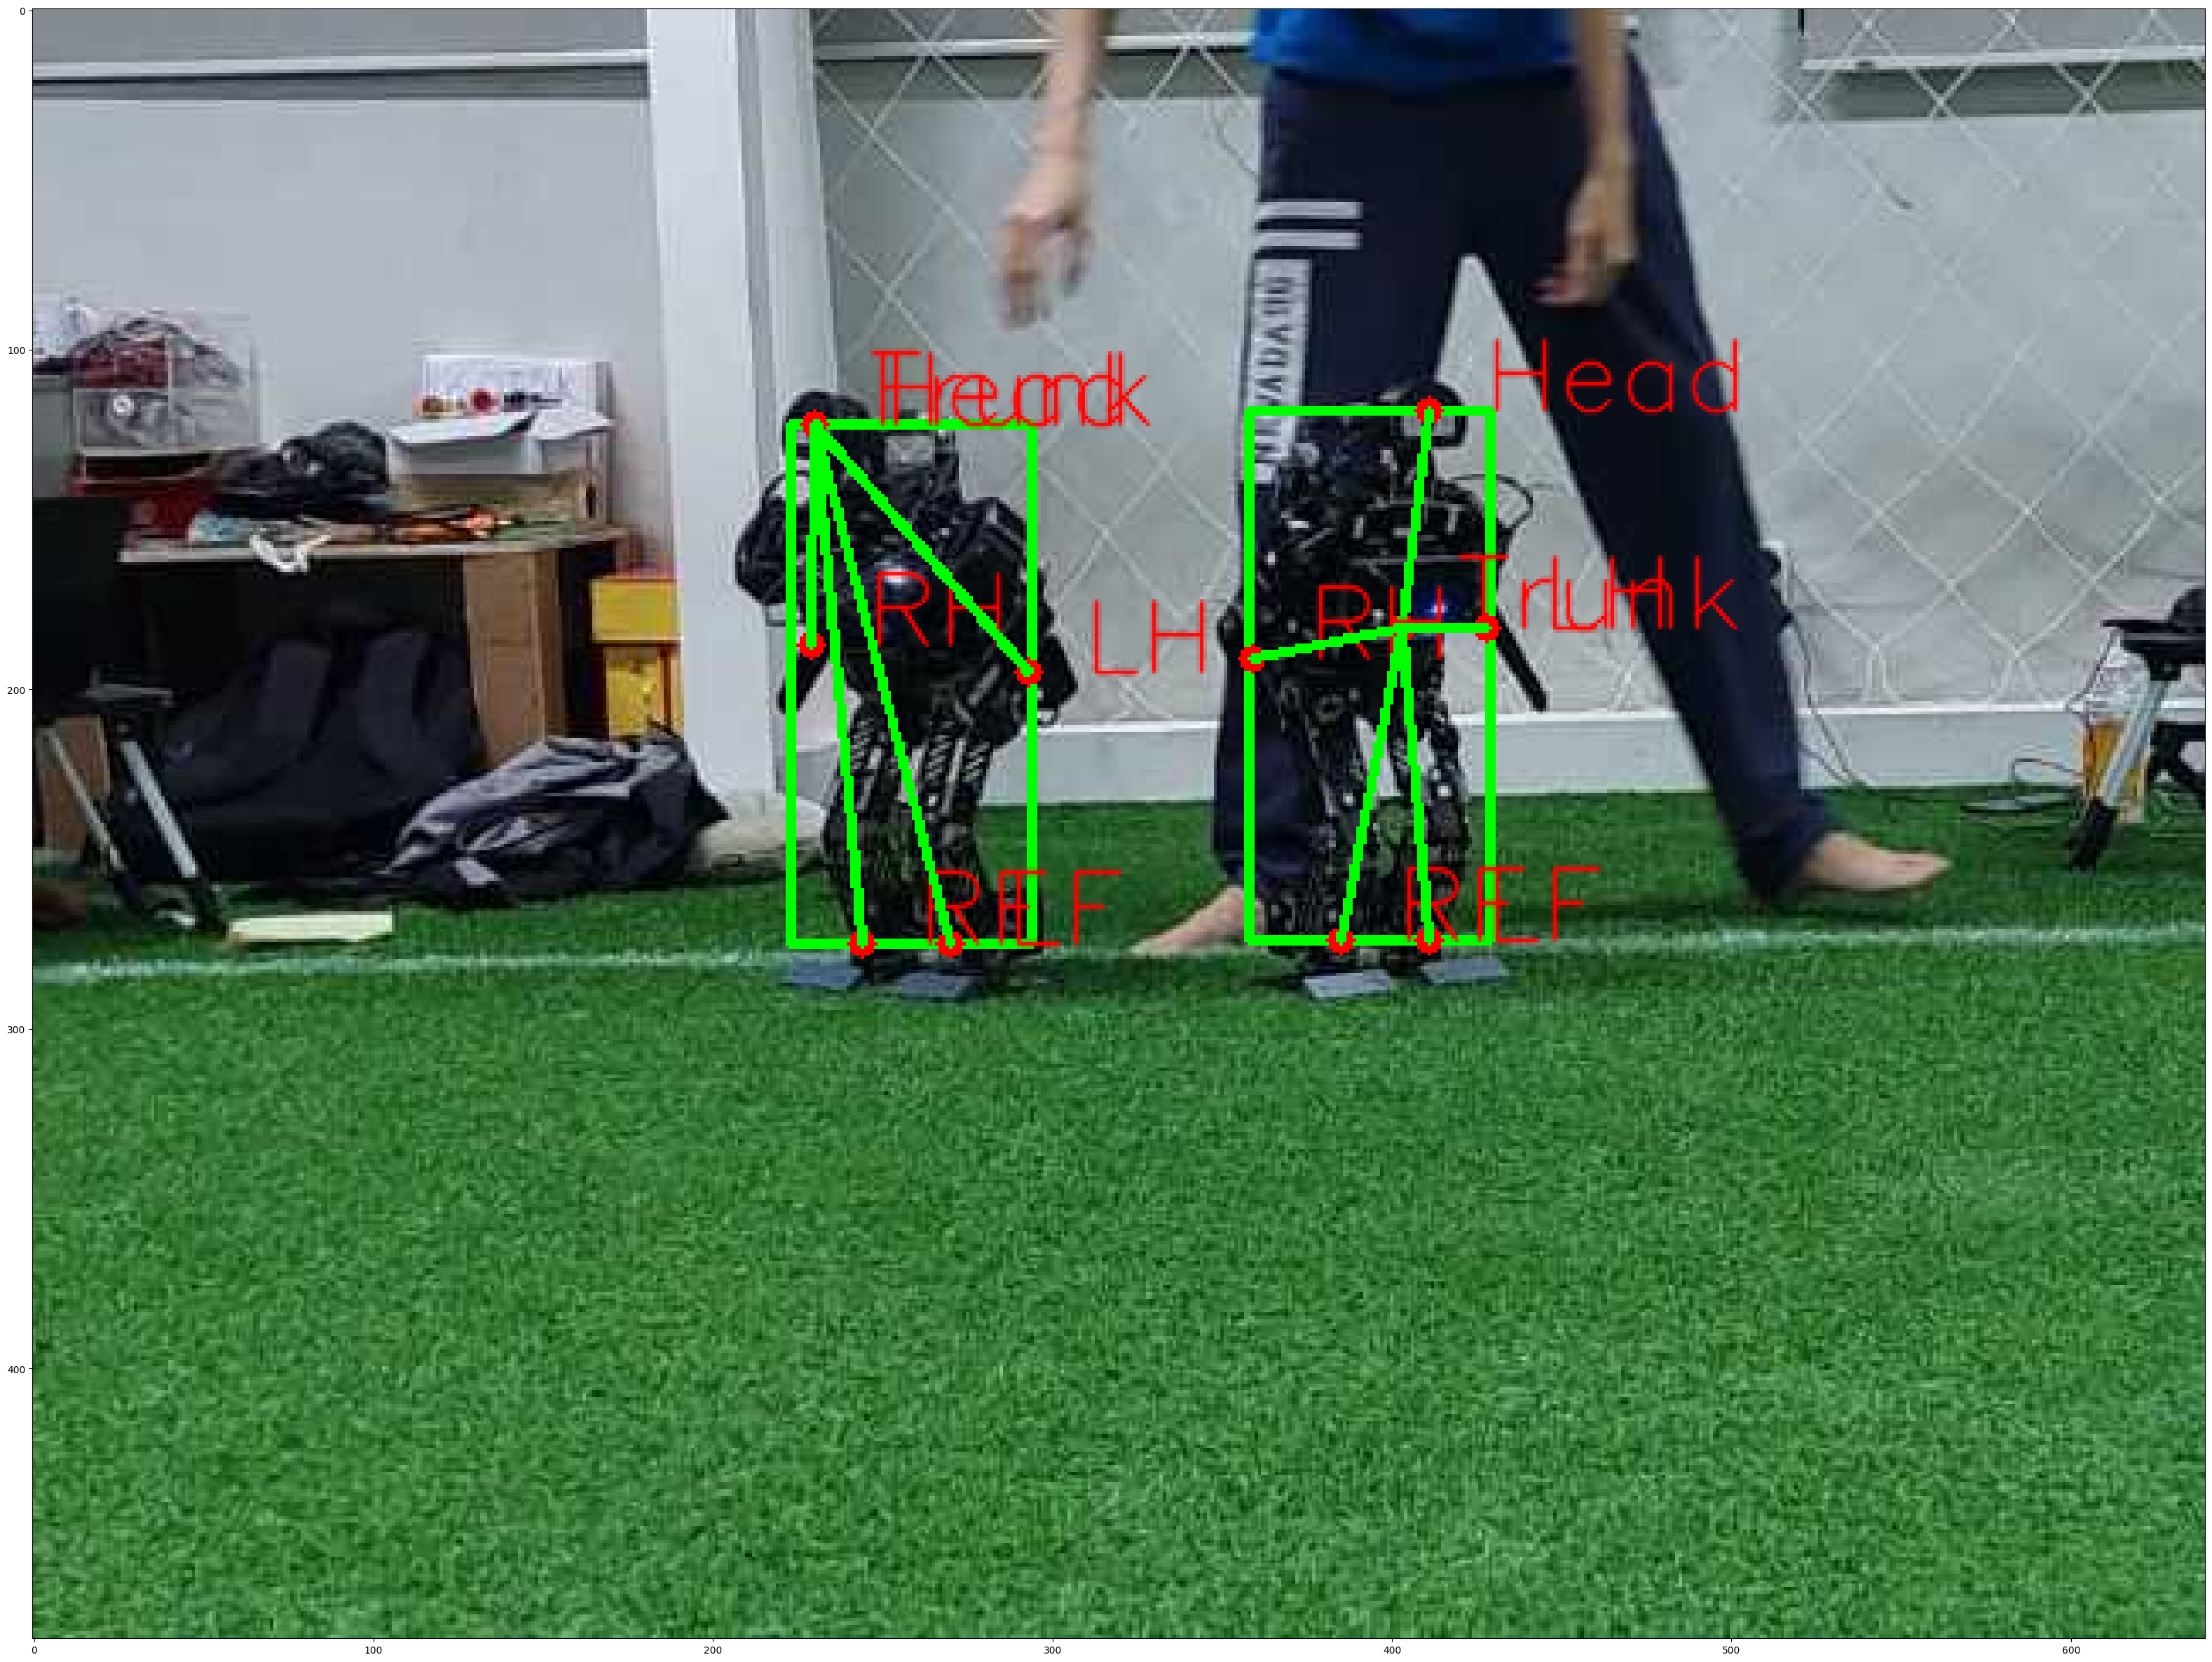

In [27]:
scores = outputs[0]['scores']

high_scores_idxs = np.where(scores > 0.55)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(outputs[0]['boxes'][high_scores_idxs], outputs[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in outputs[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])
print(keypoints)
bboxes = []
for bbox in outputs[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(orig_frame, bboxes, keypoints)

In [16]:
outputs[0]['boxes'][high_scores_idxs]

tensor([[432.2406, 143.5179, 511.4897, 322.9104]])